<img src="images/coiled-logo.svg"
     align="right"
     width="5%"
     alt="Coiled logo\">

### Sign up for the next live session at https://www.coiled.io/tutorials


<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">
     
# Parallelize Python with <br/> Dask Futures

In this lesson we will normal for-loopy Python code that looks like this:

```python
urls = [...]
results = []
for url in urls:
    page = download(url)
    result = process(page)
    results.append(result)
```

Or mor dynamic Python code that looks like this:

```python
urls = [...]
results = []
while urls:
    url = urls.pop()
    page = download(url)
    result = process(page)
    results.append(result)
    
    new_urls = scrape(page)
    urls.extend(new_urls)
```

And parallelize it out into a dynamic task graph (image right) and then run that code in parallel.  

This will give us the foundation of parallel computing used by Dask.  In future examples we'll see how other library developers have used this to give us higher level parallel APIs .




## Outline

We will learn how to use futures, and then use them on a real-world example, first in a simple case, and then in a complex case:

1.  (Learn) How to use Features 
2.  (Do) Use futures to download and parse webpages
3.  (Learn) Dynamic/changing workloads
4.  (Do) Crawl and scrape a website




## 1.  (Learn) How to use Futures



### Parallel Code with low-level Futures

This is an example of an embarrassingly parallel computation.  We want to run the same Python code on many pieces of data.  This is a very simple and also very common case that comes up all the time.

Let's learn how to do this with [Dask futures](https://docs.dask.org/en/stable/futures.html)

First, we're going to see a very simple example, then we'll try to parallelize the code above.


### Set up a Dask cluster locally

In [ ]:
from dask.distributed import Client

client = Client()
client

### Dask Futures introduction

In [ ]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def double(x):
    time.sleep(random.random())
    return 2 * x

def add(x, y):
    time.sleep(random.random())
    return 2 * x
    

Dask futures lets us run Python functions remotely on parallel hardware.  Rather than calling the function directly:

In [ ]:
%%time

y = inc(10)
z = double(y)
z

We can ask Dask to run that function, `slowinc` on the data `10` by passing each as arguments into the `client.submit` method.  The first argument is the function to call and the rest of the arguments are arguments to that function.

Normal Execution

```python
result = function(*args, **kwargs)
```

Submit function for remote execution

```python
future = client.submit(function, *args, **kwargs)  # instantaneously fire off work
...
result = future.result()  # when we need, block until done and collect the result
```

In [ ]:
%%time

y = client.submit(inc, 10)
z = client.submit(double, y)
z

You'll notice that that happened immediately.  That's because all we did was submit the `inc` function to run on Dask, and then return a `Future`, or a pointer to where the data will eventually be.

We can gather the future by calling `future.result()`

In [ ]:
z

In [ ]:
z.result()

## Submit many tasks in a loop

We can submit lots of functions to run at once, and then gather them when we're done.  This allows us to easily parallelize simple for loops.

*This section uses the following API*:

-  [Client.submit and Future.result](https://docs.dask.org/en/stable/futures.html#submit-tasks)


### Sequential code

In [ ]:
%%time 

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = []

for x in data:
    y = inc(x)
    z = double(y)
    results.append(z)
    
results

### Parallel code

In [ ]:
%%time 

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = []

for x in data:
    y = client.submit(inc, x)
    z = client.submit(double, y)
    results.append(z)
    
results = client.gather(results)
results

## Lessons:

1.  Submit a function to run elsewhere

    ```python
    y = f(x)
    future = client.submit(f, x)
    ```
    
    
2.  Get results when you're done

    ```python
    y = future.result()
    # or 
    results = client.gather(futures)
    ```

## 2. (Do) Use futures to download and parse webpages

### Sequential Code

The code below downloads 50 question pages from a Stack Overflow tag, parses those pages, and collects the title and list of tags from each page.

We then count up all the tags to see what are the most popular kinds of questions.  We divide this code into four sections:

1.  Define useful functions
2.  Get a list of pages to download and scrape
3.  Download and scrape
4.  Analyze results

#### Define useful functions

In [ ]:
import re
import requests
from bs4 import BeautifulSoup
import time

def download(url: str, delay=0) -> str:
    time.sleep(delay)
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        response.raise_for_status()
        
        
def scrape_title(body: str) -> str:
    html = BeautifulSoup(body, "html.parser")
    return str(html.html.title)


def scrape_question_links(body: str, base_url="") -> list[str]:
    html = BeautifulSoup(body, "html.parser")
    
    return [
        str(base_url + link.attrs["href"]).split("?")[0]
        for link in html.find_all("a") 
        if re.match("/questions/\d{5}", link.attrs.get("href", ""))
    ]


def scrape_tags(body: str) -> list[str]:
    html = BeautifulSoup(body, "html.parser")
    
    return sorted({
        str(list(link.children)[0])
        for link in html.find_all("a", class_="post-tag")
    })

#### Get list of pages to download and scrape

In [ ]:
url = "https://stackoverflow.com/questions/tagged/pandas"
body = download(url)
urls = scrape_question_links(body, base_url="https://stackoverflow.com")
urls[:5]

#### Download and scrape

In [ ]:
%%time

all_tags = []
titles = []

for url in urls:
    page = download(url)
    print(".", end="")
    tags = scrape_tags(page)
    title = scrape_title(page)
    
    all_tags.append(tags)
    titles.append(title)
print()

#### Analyze Results

Aggregate tags to find related topics

In [ ]:
import collections

tag_counter = collections.defaultdict(int)

for tags in all_tags:
    for tag in tags:
        tag_counter[tag] += 1
        
sorted(tag_counter.items(), key=lambda kv: kv[1], reverse=True)[:10]

### Exercise: Parallelize this code

Take the code above, and use Dask futures to run it in parallel

Which sections should we think about parallelizing?

In [ ]:
url = "https://stackoverflow.com/questions/tagged/pandas"
body = download(url)
urls = scrape_question_links(body, base_url="https://stackoverflow.com")

In [ ]:
%%time

all_tags = []
titles = []

for url in urls:
    page = download(url)
    print(".", end="")
    tags = scrape_tags(page)
    title = scrape_title(page)
    
    all_tags.append(tags)
    titles.append(title)
print()

##### Solution

In [ ]:
%%time

all_tags = []
titles = []

for url in urls:
    page = client.submit(download, url)
    tags = client.submit(scrape_tags, page)
    title = client.submit(scrape_title, page)
    
    all_tags.append(tags)
    titles.append(title)
    
all_tags = client.gather(all_tags)
titles = client.gather(titles)

In [ ]:
import collections

tag_counter = collections.defaultdict(int)

for tags in all_tags:
    for tag in tags:
        tag_counter[tag] += 1
        
sorted(tag_counter.items(), key=lambda kv: kv[1], reverse=True)[:10]

### Exercise:  Scale out

There are different reasons to scale out for this problem:

1.  Parallelize bandwidth
2.  StackOverflow's rate-limits won't affect us as much if we spread out our requests from many different machines
3.  ~CPU Processing speed~ (not really an issue here)

Let's ask for some machines from Coiled, and switch our Dask client to use that cluster.

In [ ]:
client.close()

In [ ]:
import coiled

cluster = coiled.Cluster(
    n_workers=20,
    worker_cpu=2,
    worker_options={"nthreads": 1},
)

client = cluster.get_client()

You can then insert the Dashboard URL into the text field at the top of the Dask JupyterLab extension sidebar, or press the Magnifying Glass icon (🔍) in the upper right of that section.

This will change your dashboard plots to the new cluster.

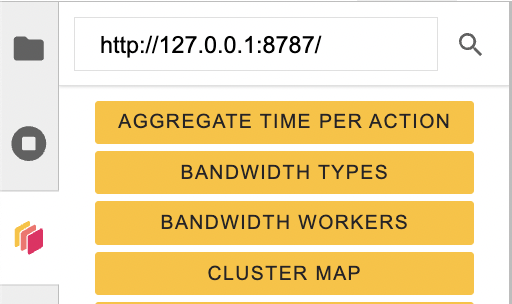

Now rerun your computation and see how it feels.

## 3. (Learn) Evolving computations

Dask futures are flexible.  There are many ways to coordinate them including ...

1.  Distributed locks and semaphores
2.  Distributed queues
3.  Launching tasks from tasks
4.  Global variables
5.  ... [and lots more](https://docs.dask.org/en/stable/futures.html)

We're going to get a taste of this by learning about one Dask futures feature, [`as_completed`](https://docs.dask.org/en/stable/futures.html#distributed.as_completed), which lets us dynamically build up a computation as it completes.

We will use this to build a parallel web crawler over Stack Overflow.  

1.  First, we'll build this sequentially.
2.  Second, we'll learn how `as_completed` works in a simple example
3.  Third, we'll convert the sequential code into parallel code

### Sequential Code to Crawl Stack Overflow

In [ ]:
%%time
from collections import deque

urls = deque()
urls.append("https://stackoverflow.com/questions/tagged/dask")  # seed with a single page

all_tags = []
titles = []
seen = set()
i = 0

while urls and i < 10:
    url = urls.popleft()
    
    # Don't scrape the same page twice
    if url in seen:  
        continue
    else:
        seen.add(url)
    
    print(".", end="")
    i += 1
    
    # This is like before
    page = download(url)
    tags = scrape_tags(page)
    title = scrape_title(page)
    all_tags.append(tags)
    titles.append(title)

    # This is new!  
    # We scrape links on this page, and add them to the list of URLs
    new_urls = scrape_question_links(page, base_url="https://stackoverflow.com")
    urls.extend(new_urls)

In [ ]:
titles

In [ ]:
all_tags

### Learn about `as_completed`

Let's use our `inc`/`dec` example from before, and add up the results as they come in.

In [ ]:
%%time 

total = 0

for x in range(16):
    y = inc(x)
    z = double(y)
    total += z
    print("Total:", total, end="\r")

In [ ]:
%%time 

total = 0
futures = as_completed()

for x in range(200):
    y = client.submit(inc, x)
    z = client.submit(double, y)
    futures.add(z)

while futures.count() > 1:
    a = futures.next()
    b = futures.next()
    c = client.submit(add, a, b)
    futures.add(c)
    print("Some results:", a.result(), b.result(), end="\r")
    
total = futures.next().result()
print("Final Result:", total)

### Exercise: Parallelize code to crawl Stack Overflow

In [ ]:
%%time
from collections import deque
from dask.distributed import as_completed

urls = deque()
urls.append("https://stackoverflow.com/questions/tagged/jupyter")  # seed with a single page

all_tags = []
titles = []
url_futures = as_completed()
seen = set()
i = 0

while urls or not url_futures.is_empty() and i < 1000:
    if not urls:
        future = url_futures.next()
        new_urls = future.result()
        urls.extend(new_urls)
        continue
    
    url = urls.popleft()
    
    if url in seen:
        continue
    else:
        seen.add(url)
    
    print(".", end="")
    i += 1

    page = client.submit(download, url, delay=0.25)
    tags = client.submit(scrape_tags, page)
    title = client.submit(scrape_title, page)

    new_urls = client.submit(scrape_question_links, page, base_url="https://stackoverflow.com")
    url_futures.add(new_urls)

    all_tags.append(tags)
    titles.append(title)

In [ ]:
client.gather(titles[:20])

In [ ]:
all_tags = client.gather(all_tags)

In [ ]:
import collections

tag_counter = collections.defaultdict(int)

for tags in all_tags:
    for tag in tags:
        tag_counter[tag] += 1
        
sorted(tag_counter.items(), key=lambda kv: kv[1], reverse=True)[:20]

In [ ]:
import time

import pandas as pd
import requests
from bs4 import BeautifulSoup

In [ ]:
def get_title(page_num):
    """ Get title of a SO questions page"""
    url = f"https://stackoverflow.com/questions?tab=newest&page={page_num}"
    req = requests.get(url)
    html = BeautifulSoup(req.text, "html.parser")

    return html.title.text

In [ ]:
page_2 = get_questions_page_title(2)
page_2

### Serial code to get 8 pages would be:

In [ ]:
%%time
page_title = []
for p in range(1, 9):  # page numbers start in 1
    page_title.append(get_questions_page_title(p))

In [ ]:
page_title[:3]

### Exercise

Run the code in parallel, using futures.

In [ ]:
from dask.distributed import Client, wait

In [ ]:
client = Client(n_workers=4)
client

In [ ]:
# Solution
futures = []
for p in range(1, 9):
    future = client.submit(get_questions_page_title, p)
    futures.append(future)

futures

In [ ]:
futures[0]

In [ ]:
futures[0].result()

In [ ]:
results = [future.result() for future in futures]
results

**Extra:**

To be able to `%%time` the cell and compare times with the serial version, you will need to wait for the futures to finish doing `wait(futures)`. If you try to do that and re run the cell, you will notice it is immediate, this is because by default, distributed assumes that all functions are pure. Pure functions:

- always return the same output for a given set of inputs
- do not have side effects, like modifying global state or creating files

 
You can use the `pure=False` keyword argument in the `client.submit()`. Modify your solution to match this code


```python
%%time
futures = []
for p in range(1,9):
    future = client.submit(get_questions_page_title, p, pure=False)
    futures.append(future)
    
wait(futures)
```

**`client.map()`**

With `client.submit()` you can submit individual functions for evaluation with one set of inputs, and together with a `for-loop` you can also evaluate over a sequence of inputs. `client.map()` provides a simpler interface to perform the former, let's see how to perform the example above now using `client.map()`


In [ ]:
futures = client.map(get_questions_page_title, range(1, 9))

`client.map()` returns a list of futures, you can block on the computation and gather the result by doing:

In [ ]:
res = client.gather(futures)
res

### Futures are great...

The other big benefit of `futures` is that the intermediate results, represented by `futures`, can be passed to new tasks without having to pull data locally from the cluster. New operations can be setup to work on the output of previous jobs that have not even begun yet.

Let's brake our steps into multiple functions

- `request_html_page`: given a url returns the html of that page
- `get_page_html_links`: given a SO questions page number returns a the html for that page number.
- `get_post_links_per_page`: given a SO questions html page, returns a list with the posts of that page.


<center>
<img src="https://raw.githubusercontent.com/coiled/dask-tutorial/main/images/dask_SO_posts_links.png"
     width="65%"
     alt="dask post links\">
</center>




In [ ]:
def request_html_page(url):
    """Given a url returns the html of that page"""
    req = requests.get(url)
    html = bs(req.text, "html.parser")
    return html

In [ ]:
def get_page_html_links(tag: str, page: int, query_filter="MostVotes"):
    """ Given a SO questions page number returns a the html for that page number
    for a tag and query_filter.
    """
    base_url = "https://stackoverflow.com/questions/tagged/"

    page_url = f"{base_url}{tag}?sort={query_filter}&page={page_num}"

    page_html = request_html_page(page_url)

    return page_html

In [ ]:
response = requests.get("https://www.google.com/shfsfhfhfg")

In [ ]:
response.raise_for_status()

In [ ]:
import re
import requests
from bs4 import BeautifulSoup

def download(url: str) -> str:
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        response.raise_for_status()
        
def get_title(body: str) -> str:
    html = BeautifulSoup(body, "html.parser")
    return html.html.title


def scrape_question_links(body: str, base_url="") -> list[str]:
    html = BeautifulSoup(body, "html.parser")
    
    return [
        base_url + link.attrs["href"]
        for link in html.find_all("a", class_="s-link") 
        if re.match("/questions/\d{5}", link.attrs.get("href", ""))
    ]

def scrape_tags(body: str) -> list[str]:
    html = BeautifulSoup(body, "html.parser")
    
    return sorted({
        list(link.children)[0]
        for link in html.find_all("a", class_="post-tag")
    })


In [ ]:
urls = ["https://stackoverflow.com/questions/tagged/dask"]
url = urls.pop()

body = download(url)
title = get_title(body)

In [ ]:
title

In [ ]:
urls = ["https://stackoverflow.com/questions/tagged/dask"]
url = urls.pop()
body = download(url)
questions = scrape_question_links(body, base_url="https://stackoverflow.com/")

In [ ]:
questions

In [ ]:
url = questions[1]

body = download(url)
tags = scrape_tags(body)
questions = scrape_question_links(body)

In [ ]:
questions

In [ ]:
tags

In [ ]:
print(body)

In [ ]:
questions

In [ ]:
debug

In [ ]:
def get_post_links_per_page(html_page):
    """Given a SO questions html page, returns a list with the posts of that page."""
    question_href = html_page.find_all("a", class_="s-link")[2:-1]

    question_link = [f"https://stackoverflow.com{q['href']}" for q in question_href]

    return question_link

### Explore the functions:  

In [ ]:
page_url

In [ ]:
base_url = "https://stackoverflow.com/questions/tagged/"
tag = "dask"
query_filter = "MostVotes"
page_num = 1
page_url = f"{base_url}{tag}?sort={query_filter}&page={page_num}"
page_url = "https://stackoverflow.com/questions/38882660/at-what-situation-i-can-use-dask-instead-of-apache-spark"
response = requests.get(page_url)
html = BeautifulSoup(response.text, "html.parser")

import re
re.match("/questions/\d{5}", "/questions/45545110/make-pandas-dataframe-apply-use-all-cores")

import toolz
list(toolz.unique([link for link in html.find_all("a", class_="post-tag")]))

In [ ]:
re.match("/questions/\d{5}", "/questions/45545110/make-pandas-dataframe-apply-use-all-cores")


In [ ]:
html

In [ ]:
link = _[5]

In [ ]:
link.attrs["href"].startswith("/questions")

In [ ]:
page_number = 3

page_3_html = get_page_html_links(page_num=page_number)

In [ ]:
post_links_page_3 = get_post_links_per_page(page_3_html)

In [ ]:
len(post_links_page_3)

In [ ]:
post_links_page_3[:3]

### Get post links for multiple pages

In [ ]:
# serial code
page_posts_links = []
for page in range(1, 5):
    page_html = get_page_html_links(page_num=page)
    posts_links = get_post_links_per_page(page_html)

    page_posts_links.append(posts_links)

In [ ]:
len(page_posts_links)

In [ ]:
[len(l) for l in page_posts_links]

**Parallel code: using `client.map()`**

We can get first the futures for every page html, and pass those futures as the iterator to get the links per page.

In [ ]:
pages_html_futures = client.map(get_page_html_links, range(1, 5))
wait(pages_html_futures)  # wait until completed

**`wait()`**

Notice that here we used `wait()`, you can wait on a future or collection of futures using the `wait` function, which blocks until all futures are finished or have erred. This is useful when you need the all the futures to be completed to proceed with your computations. 

In [ ]:
pages_html_futures[0]

### Exercise:

Using `client.map()` and the `pages_html_futures` you just got, to get the post's links for the four pages, in parallel.

In [ ]:
# Solution
posts_links_futures = client.map(get_post_links_per_page, pages_html_futures)
posts_links_futures

In [ ]:
posts_links_futures[0]

In [ ]:
posts_links_futures[0].result()[:3]

**`as_completed()`**

In the example above we waited for the the `pages_html_futures` to finish before we proceed to get the `posts_links_futures`. However, we can get the `post_links_futures` for every page as the `pages_html_futures` finish. 

`as_completed()` return futures in the order in which they complete. It returns an iterator that yields the input future objects in the order in which they complete. 

In [ ]:
from dask.distributed import as_completed

In [ ]:
pages_html_futures = client.map(
    get_page_html_links, range(1, 5), pure=False
)  # use pure=False to re-compute

post_links_futures = []
for p in as_completed(pages_html_futures):
    post_links_futures.append(client.submit(get_post_links_per_page, p))

In [ ]:
post_links_futures

## Clean up

In [ ]:
cluster.shutdown()
client.close()

### Useful links

- https://tutorial.dask.org/05_futures.html

**Useful links**

* [Futures documentation](https://docs.dask.org/en/latest/futures.html)
* [Futures screencast](https://www.youtube.com/watch?v=07EiCpdhtDE)
* [Futures examples](https://examples.dask.org/futures.html)

### Next lesson

Register [here](https://www.coiled.io/tutorials) for reminders. 

In the next lesson, we’ll learn some best practices around working with larger-than-memory datasets. We’ll use the Uber/Lyft dataset to:

- Manipulate Parquet files and optimize queries
- Navigate inconvenient file sizes and data types
- Extract useful features with Dask Dataframe

By the end, we’ll learn the advantages of working with the Parquet file format and how to efficiently perform an exploratory analysis with Dask.